In [1]:
#!conda install pytorch==1.7.1 torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 2.5 MB/s eta 0:00:011
     |████████████████████████████████| 76 kB 7.2 MB/s  eta 0:00:01
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41913 sha256=1867c43bdfef1f02e2e81cf9d96a60ae969011b43d7d3c850116ba8b25431015
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ff/2a/24/75041425faf3347ab146a4a3d0484f723b2c44a7966a06e3f0
Successfully built ftfy
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9__cq4dx
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-9__cq4dx
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369067 sha256=752eefb776b27f327145fa89dc9a5d1d27aedebc4559ccff753642034a71714f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ug7n48o1/wheels/41/36/e0/af6191bd08c254b17d779b05de8282c9ea81ef7048abbe290

### clip zero-shot

In [1]:
import torch
import clip
import os
from PIL import Image
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [59]:
def preprocess_folder_savenpy(img_folder):
    res = []
    images = os.listdir(img_folder)
    
    for i in images:
        image_path = os.path.join(img_folder,i)
        
        image_feature = model.encode_image(preprocess(Image.open(image_path)).unsqueeze(0).to(device))
        image_feature = (image_feature / image_feature.norm(dim=-1, keepdim=True)).cpu().detach().numpy()

        res.append(image_feature)
    
    b=np.concatenate(res,axis=0)

    return images, b

In [60]:
def image_show(path):
    lena = mpimg.imread(path) # 读取和代码处于同一目录下的 lena.png
    # 此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
    lena.shape #(512, 512, 3)

    plt.imshow(lena) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()

def find_best_matches(text_features, photo_features, photo_ids, results_count):
    similarities = (photo_features @ text_features.T).squeeze(1)
    best_photo_idx = (-similarities).argsort()
    return [photo_ids[i] for i in best_photo_idx[:results_count]]

def pic2pic(source_image,photo_features,photo_ids,target_folder):
    # image to image
    with torch.no_grad():
        image_feature = model.encode_image(preprocess(Image.open(source_image)).unsqueeze(0).to(device))
        image_feature = (image_feature / image_feature.norm(dim=-1, keepdim=True)).cpu().detach().numpy()
        best_photo_ids = find_best_matches(image_feature, photo_features, photo_ids, 5)
    
    print ("source")
    image_show(source_image)
    print ("search_res")
    image_show(os.path.join(target_folder,photo_ids[1]))
    
    return photo_ids[1]

def main(source_image,target_folder):
    photos, photo_features = preprocess_folder_savenpy(target_folder)
    res_id = pic2pic(source_image,photo_features,photos)
    return os.path.join(target_folder,res_id)

source


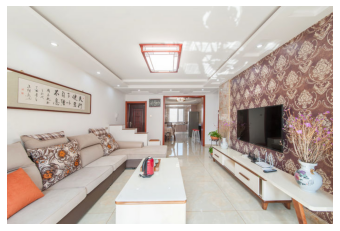

search_res


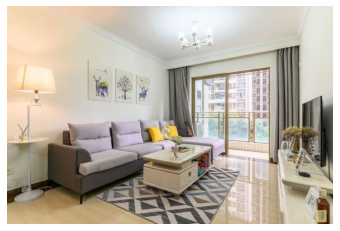

CPU times: user 14.9 s, sys: 101 ms, total: 15 s
Wall time: 12.4 s


In [61]:
%%time

    source_image = './data/livingroom/10134576360_1112923_283.jpg'
    target_folder = ('./data/livingroom')

main(source_image,target_folder)
